In [9]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

import umap

In [4]:
dataset = datasets.load_dataset('bookcorpus')['train']
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

dataset[:3]

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for bookcorpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bookcorpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

In [23]:
subpath = '20240704.20:55:54' # 4 abs_bert, bookcorpus
subpath = '20240704.21:19:36' # 5 abs_bert, wiki
# subpath = '20240704.21:26:11' # 6 abs_bert, bookcorpus, xavier_init_embedding
subpath = '20240704.21:33:23' # 7 abs_bert, wiki, xavier_init_embedding
# subpath = '20240709.10:26:55' # abs_architecture, lr 1e-5~1e-3, early exploded
subpath = '20240709.11:13:35' # abs_architecture, lr 1e-5~1e-3, exploded at 10000
subpath = '20240709.12:14:48' # time_attention, lr 1e-5~1e-3, exploded at before 6000

subpath = '20240710.23:13:03' # all1_as_pivot, mask_prob0.15
subpath = '20240711.03:33:04' # all1_layerNorm, lr 2e-5
subpath = '20240711.03:33:24' # all1_layerNorm, lr 5e-6
# subpath = '20240711.03:48:45' # all1_layerNorm, lr 1e-6
subpath = '20240711.15:40:27' # wiki, lr 4e-5
subpath = '20240711.16:14:06' # multi granularity lr4e-5
subpath = '20240711.17:23:01' # log_granularity [1,2,2,3,5,5,6,6], bookcorpus, lr 4e-5

weight norms, min: 0.10725504159927368, max: 0.7680855989456177
min norms: ['[PAD]', 'gambling', 'benedict', 'mummy', 'mimi', 'mechanism', 'sterile', 'bonfire', 'processing', 'archibald']
max norms: ['her', 'in', 'it', 'me', 'was', "'", 'to', 'the', 'and', ',']
bias norms, min: -0.07141588628292084, max: 0.07863214612007141
min norms: ['[PAD]', 'ʼ', 'अ', 'ђ', '##真', '##ර', 'racecourse', '1663', 'ɣ', 'depicts']
max norms: ['her', 'a', 'it', 'me', "'", 'to', 'and', 'the', '.', ',']


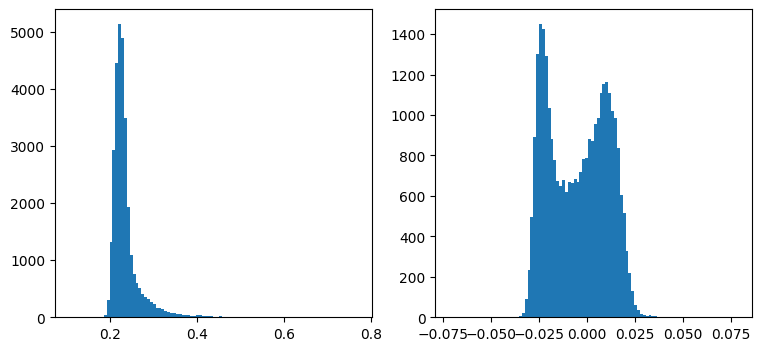

In [24]:
epoch_num = 0
batch_num = 50000


folder_path = pathlib.Path('data/limanet/')

model = torch.load(folder_path/subpath/f'epoch_{epoch_num}-batch_{batch_num}-model.pt', map_location='cpu')
word_reprs = model.word_embeddings().detach()

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(word_reprs, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = model.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [25]:
layer_num = 0

num_heads = model.base_model.num_heads
dim = model.base_model.dim
hidden_dim = dim // num_heads

w = model.word_embeddings().detach()
Q = model.base_model.layers[layer_num].Q.weight.detach()
K = model.base_model.layers[layer_num].K.weight.detach()

sims = cosine_similarity(w, Q)
q_tops = sims.argsort(axis=0)[::-1][:5].T

sims = cosine_similarity(w, K)
k_tops = sims.argsort(axis=0)[::-1][:5].T

In [26]:
for h in range(num_heads):
  # print(q_tops[h*(hidden_dim+1):(h+1)*(hidden_dim+1)], k_tops[h*hidden_dim:(h+1)*hidden_dim])
  q_heads = q_tops[h*(hidden_dim+1):(h+1)*(hidden_dim+1)]
  k_heads = k_tops[h*hidden_dim:(h+1)*hidden_dim]

  q_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in q_heads]
  k_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in k_heads]

  q_lens = [len(''.join(tokens)) for tokens in q_tokens]
  k_lens = [len(''.join(tokens)) for tokens in k_tokens]
  q_max = max(q_lens)
  k_max = max(k_lens)

  for q, k, q_len, k_len in zip(q_tokens, k_tokens, q_lens, k_lens):
    # print(q, k, q_len, k_len)

    print(f"{', '.join(q)}, {' '*(q_max-q_len)}{', '.join(k)}{' '*(k_max-k_len)}")

  print(q_tokens[-1])
  print()

rotting, 2, roommate, transparent, mercedes,                jonas, rand, dea, ##cate, ##ie                          
javelin, freighter, idle, reid, linen,                      suspended, ##kled, facility, magnificent, ##mel         
interface, clothed, vibe, genre, ##dur,                     southern, managers, elite, whose, plastic               
papyrus, credentials, 1804, ked, institutes,                unmistakable, damp, akira, hillside, affinity           
pension, articles, collaboration, mobility, prepare,        [unused766], grammar, ##tsa, polls, forgiveness         
peacefully, scarlet, kelsey, ##suit, firmly,                organism, ethics, attraction, skills, boasted           
would, ended, might, could, should,                         fran, joey, daphne, belle, muddy                        
aria, civilizations, initially, angelica, newt,             mario, hamish, yer, island, til                         
scoffed, ministerial, ##bara, erik, ##erton,                wive